In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from functools import reduce

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [3]:
df = pd.read_csv('Raw_Data.csv',header=0).round(1)

In [4]:
#Original Data
df.head()

,%T254,%T215,Flow,UVS,Actual Power,N,RED
0,88.6,63.3,257.6,23.2,6.0,2,71.0
1,88.6,63.3,257.6,23.3,6.0,2,72.8
2,88.6,63.3,257.6,23.3,6.0,2,73.6
3,93.0,82.8,189.1,24.6,3.5,2,98.1
4,93.0,82.8,189.1,24.7,3.5,2,98.8


In [5]:
#Synthetic data for 1 and 2 lamps - based on UV dose multiplication
df1 = df.loc[df['N']==1].copy()
df1.loc[:, 'RED']*=2
df1.loc[:, 'N']=2

df2 = df.loc[df['N']==2].copy()
df2.loc[:, 'RED']/=2
df2.loc[:, 'N']=1

df=df.append(df1,ignore_index=True)
df=df.append(df2,ignore_index=True)

In [6]:
# Duplicate the situation for 3 and 4 lamps:
df_3 = df.loc[df['N']==1].copy()
df2.loc[:, 'RED']*=3
df2.loc[:, 'N']=3

df_4 = df.loc[df['N']==2].copy()
df2.loc[:, 'RED']*=2
df2.loc[:, 'N']=4

df=df.append(df_3,ignore_index=True)
df=df.append(df_4,ignore_index=True)

<AxesSubplot:xlabel='%T254', ylabel='%T215'>

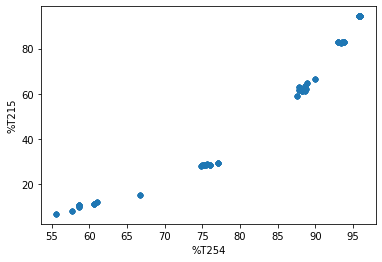

In [7]:
df.plot.scatter(x='%T254',y='%T215')

In [8]:
# Transform UVT into exp(-UVT/100)
df['%T254'] = np.exp(-df['%T254']/100)
df['%T215'] = np.exp(-df['%T215']/100)

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_features = sc.fit_transform(df.values)
#restore column names
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [10]:
X = scaled_features_df.drop('RED',axis=1)
y = scaled_features_df['RED']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

In [12]:
# HyperParameters:
Dense1 = 10
Dense2 = 4
LearningRate = 0.01
dropout = 0.1
GNoise = 0.1
Epochs = 100

L2regularization = 0.02
Bias_regularization = 0.02

#Number of Features (may be worth to try PCA to reduce
Features = 6

In [13]:
### Experimental ###
def createModel(Dense1, Dense2, LearningRate, dropout, GNoise, L2regularization, Bias_regularization):
    model = Sequential()
    model.add(InputLayer(input_shape=(Features,)))
    model.add(GaussianNoise(GNoise))
    model.add(Dense(Dense1, kernel_regularizer=l2(L2regularization), bias_regularizer=l2(Bias_regularization), activation='softmax'))
    model.add(Dropout(dropout))
    model.add(Dense(Dense2, 'softmax'))
    model.add(Dense(1, 'linear'))
    #model1.summary()
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LearningRate), metrics=[RootMeanSquaredError()])
    return model

In [14]:
grid = dict(Dense1 = [5,7,10],
            Dense2 = [3,4,5,6],
            LearningRate = [0.01],
            dropout = [0.1],
            GNoise = [0.1],
            L2regularization = [0.01],
            Bias_regularization = [0.01]
            )

print('Total fits per parametric grid = {}'.format(reduce(lambda x, y: x*y, [len(grid[key]) for key in grid.keys()]))) # calculate number of test-parameters

estimator = KerasRegressor(build_fn=createModel)
modelGrid = GridSearchCV(estimator = estimator, param_grid = grid, cv=5, n_jobs=-1, verbose=2)
modelGrid.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=Epochs)

Total fits per parametric grid = 12
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/100
6/6 [==============================] - 0s 40ms/step - loss: 1.1619 - root_mean_squared_error: 1.0490 - val_loss: 0.8192 - val_root_mean_squared_error: 0.8744
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1189 - root_mean_squared_error: 1.0329 - val_loss: 0.7993 - val_root_mean_squared_error: 0.8669
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0980 - root_mean_squared_error: 1.0257 - val_loss: 0.7703 - val_root_mean_squared_error: 0.8526
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0671 - root_mean_squared_error: 1.0121 - val_loss: 0.7409 - val_root_mean_squared_error: 0.8362
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0253 - root_mean_squared_error: 0.9919 - val_loss: 0.7054 - val_root_mean_squared_error: 0.8147
Epoch 6/100
6/6 [==============================] - 0s 5ms

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001AB742D2DF0>,
             n_jobs=-1,
             param_grid={'Bias_regularization': [0.01], 'Dense1': [5, 7, 10],
                         'Dense2': [3, 4, 5, 6], 'GNoise': [0.1],
                         'L2regularization': [0.01], 'LearningRate': [0.01],
                         'dropout': [0.1]},
             verbose=2)

In [15]:
#Evaluate the best model
print('best score = ',modelGrid.best_score_)
best_params = modelGrid.best_params_
print(best_params)

model1 = createModel(**best_params)
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=Epochs)

best score =  -0.29183303117752074
{'Bias_regularization': 0.01, 'Dense1': 7, 'Dense2': 4, 'GNoise': 0.1, 'L2regularization': 0.01, 'LearningRate': 0.01, 'dropout': 0.1}
Epoch 1/100
6/6 [==============================] - 0s 30ms/step - loss: 1.2387 - root_mean_squared_error: 1.0814 - val_loss: 0.8869 - val_root_mean_squared_error: 0.9091
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1899 - root_mean_squared_error: 1.0646 - val_loss: 0.8509 - val_root_mean_squared_error: 0.8951
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1644 - root_mean_squared_error: 1.0572 - val_loss: 0.8292 - val_root_mean_squared_error: 0.8877
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1441 - root_mean_squared_error: 1.0513 - val_loss: 0.8115 - val_root_mean_squared_error: 0.8813
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1275 - root_mean_squared_error: 1.0463 - val_loss: 0.7960 - val_root_mean_square

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


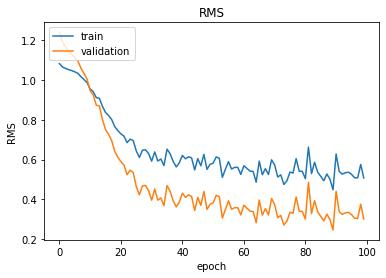

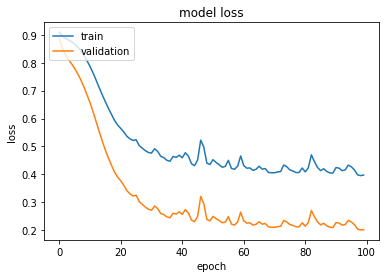

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['loss'])
plt.title('RMS')
plt.ylabel('RMS')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_root_mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
test_predictions = model1.predict(X_test)

In [18]:
X_test.insert(6,'RED',test_predictions)
y_pred = sc.inverse_transform(X_test)[:,Features]
X_test.drop('RED',axis=1).insert(Features,'RED',y_test)
y_test = sc.inverse_transform(X_test)[:,Features]

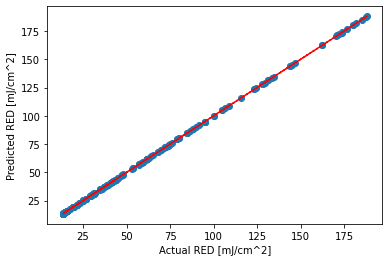

In [19]:
from numpy.polynomial.polynomial import polyfit
plt.scatter(y_test,y_pred)
# Fit with polyfit
b, m = polyfit(y_test, y_pred, 1)
plt.plot(y_test, b + m * y_test, '--', color='red')
plt.xlabel("Actual RED [mJ/cm^2]")
plt.ylabel("Predicted RED [mJ/cm^2]")
plt.show()

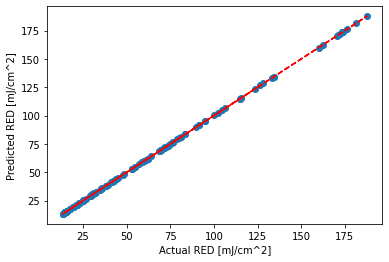

In [20]:
val_predictions = model1.predict(X_val)

X_val.insert(6,'RED',val_predictions)
y_pred = sc.inverse_transform(X_val)[:,Features]
X_val.drop('RED',axis=1).insert(Features,'RED',y_val)
y_val = sc.inverse_transform(X_val)[:,Features]

plt.scatter(y_val,y_pred)
# Fit with polyfit
b, m = polyfit(y_val, y_pred, 1)
plt.plot(y_val, b + m * y_val, '--', color='red')
plt.xlabel("Actual RED [mJ/cm^2]")
plt.ylabel("Predicted RED [mJ/cm^2]")
plt.show()

In [21]:
# Save model and scaler
from pickle import dump
model1.save('SavedModel_RED/REDmodel.h5')
#dump(model1, open('SavedModel_RED/REDmodel.pkl', 'wb'))
dump(sc, open('SavedModel_RED/scaler.pkl', 'wb'))

In [22]:
# Features format is as following:
# %T254,%T215,Flow,UVS,Actual Power,N,RED

# RED is the target

In [23]:
# Single testing point:
#88.6,63.3,257.6,23.18,6.0,2,70.98
#Target RED = 70.98

UVT254 = 88.6 # [%-1cm]
UVT215 = 63.3 # [%-1cm]
Flow = 258 # [m^3/hr]
UVS = 23.2 # [mJ/cm^2] - UV sensitivity aka D1Log
Power = 6 # [kW]
N_Lamps = 2

X_vector = sc.transform(pd.DataFrame([np.exp(-UVT254/100),np.exp(-UVT215/100),Flow,UVS,Power,N_Lamps,1]).T)[:,:Features]
# Dummy values added before the inverse transform due to the scaler preferences
RED = sc.inverse_transform([1,1,1,1,1,1,float(model1.predict(X_vector))])[Features]

In [24]:
print('RED = {}[mJ/cm^2]'.format(round(float(RED),1)))

RED = 71.3[mJ/cm^2]
